In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
# !pip install --user keras
# !pip install --user tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import model_from_json
from keras.models import load_model

pd.set_option('display.max_colwidth', 200)

In [2]:
url1="https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv"
url2="https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv"
url3="https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv"

df1=pd.read_csv(url1)
df2=pd.read_csv(url2)
df3=pd.read_csv(url3)
merged = [df1, df2, df3]

merged = pd.concat(merged)

In [3]:
merged = merged.sample(frac =0.2)

In [4]:
#creating a custom short stop words list by glancing at the corpus
stop = ['I','a','an','as','at', 'be', 'by', 'com','for', 'in', 'is', 'it','of', 'on', 'or',\
        'that','to','the','www','[name]','[religion]']

#removing stopwords and converting to lower case
merged['text'] = merged['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word not in (stop)]))


In [5]:
X = merged['text'].values
X= X.astype(str)
y = merged.iloc[:,9:].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [6]:
tokenizer = Tokenizer() #make a tokenizer
tokenizer.fit_on_texts(X_train) #fit on text


num_words=7000
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = num_words + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [7]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index)+1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix
    
embedding_dim = 300
embedding_matrix = create_embedding_matrix('glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
embedding_accuracy = nonzero_elements / vocab_size
print('embedding accuracy: ' + str(embedding_accuracy))

embedding accuracy: 0.9504427306483861


### Model Building

In [8]:
# create the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
    
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(28, activation='softmax'))
# Adam Optimiser
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           2100600   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1140736   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
Total params: 3,310,612
Trainable params: 3,310,612
Non-trainable params: 0
_________________________________________________________________


In [34]:
result = model.fit(X_train, y_train, epochs=15, verbose=True, validation_data=(X_test, y_test), batch_size=100)

Epoch 1/15
296/296 [==============================] - 266s 899ms/step - loss: 0.1460 - accuracy: 0.3184 - val_loss: 0.1330 - val_accuracy: 0.3623
Epoch 2/15
296/296 [==============================] - 278s 941ms/step - loss: 0.1310 - accuracy: 0.3756 - val_loss: 0.1281 - val_accuracy: 0.3836
Epoch 3/15
296/296 [==============================] - 264s 893ms/step - loss: 0.1244 - accuracy: 0.3907 - val_loss: 0.1263 - val_accuracy: 0.3895
Epoch 4/15
296/296 [==============================] - 229s 773ms/step - loss: 0.1182 - accuracy: 0.4162 - val_loss: 0.1259 - val_accuracy: 0.3886
Epoch 5/15
296/296 [==============================] - 189s 637ms/step - loss: 0.1131 - accuracy: 0.4379 - val_loss: 0.1267 - val_accuracy: 0.3856
Epoch 6/15
296/296 [==============================] - 187s 633ms/step - loss: 0.1079 - accuracy: 0.4559 - val_loss: 0.1307 - val_accuracy: 0.3842
Epoch 7/15
296/296 [==============================] - 187s 632ms/step - loss: 0.1028 - accuracy: 0.4812 - val_loss: 0.1345 -

In [9]:
#from the above results number of epochs = 7
result = model.fit(X_train, y_train, epochs=7, verbose=False, validation_data=(X_test, y_test), batch_size=100)

In [10]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#making predictions
y_pred = model.predict(X_test)

thresholds=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Threshold: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, precision, recall, f1))

Threshold: 0.1000, Precision: 0.2816, Recall: 0.5573, F1-measure: 0.3742
Threshold: 0.2000, Precision: 0.3794, Recall: 0.4034, F1-measure: 0.3910
Threshold: 0.2500, Precision: 0.4196, Recall: 0.3533, F1-measure: 0.3836
Threshold: 0.3000, Precision: 0.4521, Recall: 0.3123, F1-measure: 0.3694
Threshold: 0.4000, Precision: 0.5081, Recall: 0.2476, F1-measure: 0.3329
Threshold: 0.5000, Precision: 0.5469, Recall: 0.1907, F1-measure: 0.2828
Threshold: 0.6000, Precision: 0.5794, Recall: 0.1458, F1-measure: 0.2329
Threshold: 0.7000, Precision: 0.6127, Recall: 0.1077, F1-measure: 0.1831
Threshold: 0.8000, Precision: 0.6413, Recall: 0.0703, F1-measure: 0.1268
Threshold: 0.9000, Precision: 0.6518, Recall: 0.0345, F1-measure: 0.0655


Choosing threshold as 0.2 from the above results


Emotion: admiration, Precision: 0.4803, Recall: 0.5179, F1-measure: 0.4984
Emotion: amusement, Precision: 0.5285, Recall: 0.6007, F1-measure: 0.5623
Emotion: anger, Precision: 0.2870, Recall: 0.3258, F1-measure: 0.3052
Emotion: annoyance, Precision: 0.1973, Recall: 0.2544, F1-measure: 0.2222
Emotion: approval, Precision: 0.2532, Recall: 0.1853, F1-measure: 0.2140
Emotion: caring, Precision: 0.2542, Recall: 0.1347, F1-measure: 0.1761
Emotion: confusion, Precision: 0.2316, Recall: 0.2919, F1-measure: 0.2583
Emotion: curiosity, Precision: 0.2744, Recall: 0.3688, F1-measure: 0.3147
Emotion: desire, Precision: 0.4242, Recall: 0.1944, F1-measure: 0.2667
Emotion: disappointment, Precision: 0.2599, Recall: 0.1209, F1-measure: 0.1650
Emotion: disapproval, Precision: 0.2231, Recall: 0.1877, F1-measure: 0.2039
Emotion: disgust, Precision: 0.4227, Recall: 0.1306, F1-measure: 0.1995
Emotion: embarrassment, Precision: 0.5000, Recall: 0.0719, F1-measure: 0.1257
Emotion: excitement, Precision: 0.2605,

/home/ood.discovery.neu.edu/software/anaconda3/2019.10/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ood.discovery.neu.edu/software/anaconda3/2019.10/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Emotion: surprise, Precision: 0.3587, Recall: 0.2938, F1-measure: 0.3230


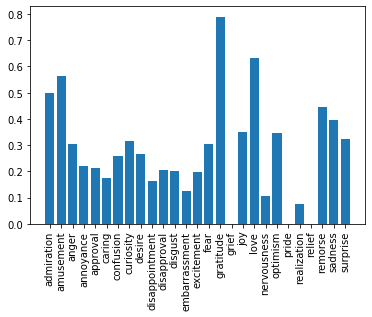

In [12]:
#Using this threshold of 0.2, we can determine the F1 score for each individual emotion:
column_names = list(merged.columns[9:])
threshold = 0.2
f1_scores = []
for i in range(0,27):
    emotion_prediction = y_pred[:,i]
    emotion_prediction[emotion_prediction>=threshold]=1
    emotion_prediction[emotion_prediction<threshold]=0
    emotion_test = y_test[:,i]
    precision = precision_score(emotion_test, emotion_prediction)
    recall = recall_score(emotion_test, emotion_prediction)
    f1 = f1_score(emotion_test, emotion_prediction)
    print("Emotion: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(column_names[i], precision, recall, f1))
    f1_scores.append(f1)
    

import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(column_names[0:27],f1_scores)
plt.xticks(rotation=90)
plt.show()

In [27]:
pred = y_pred.copy()
pred[pred>=0.2] = 1
pred[pred<0.2] =0
print("Average F1-Score across Multi-Lbales: {}".format(f1_score(y_test, pred, average='micro')))

Average F1-Score across Multi-Lbales: 0.3910436086304674
